In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import lightgbm as lgb
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [21]:
df = pd.read_excel('C:\\Users\\sasha\\Traffic_Accident_Analysis_Project\\Traffic_Accident\\data\\cleaned_dataset.xlsx')

In [22]:
print(df.shape)

(69337, 20)


In [23]:
columns_with_nulls = ["temp_c", "humidity", "wind_kph", "precip_mm", "cloud", "pressure_mb", "condition"]
df = df.dropna(subset=columns_with_nulls)

In [24]:
print(df.shape)

(69216, 20)


In [25]:
# === Features ===
features = ['acci_x', 'acci_y', 'acci_hour', 'temp_c', 'humidity', 'wind_kph', 'precip_mm', 'cloud', 'pressure_mb',
            'condition', 'day_of_week', 'season', 'part_of_day']
num_features = ['acci_x', 'acci_y', 'acci_hour', 'temp_c', 'humidity', 'wind_kph', 'precip_mm', 'cloud', 'pressure_mb']
cat_features = ['condition', 'day_of_week', 'season', 'part_of_day']

In [26]:
X = df[features].copy()
y = df['severity'].copy()

In [27]:
# === Encode Features ===
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

le_target = LabelEncoder()
y_en = le_target.fit_transform(y)

In [28]:
# === Feature Selection ===
selector = SelectKBest(chi2, k='all')
X_selected = selector.fit_transform(X, y_en)
selected_columns = selector.get_feature_names_out()
X_df = pd.DataFrame(X_selected, columns=selected_columns)

In [29]:
# Update categorical feature indices for selected data
cat_indices_fs = [i for i, col in enumerate(selected_columns) if any(cat in col for cat in cat_features)]

In [30]:
# === SMOTENC ===
smote_nc = SMOTENC(categorical_features=cat_indices_fs, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_df, y_en)

In [31]:
# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --upgrade xgboost

Note: you may need to restart the kernel to use updated packages.


In [32]:
import xgboost
print(xgboost.__version__)

3.0.2


In [33]:
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np

# 1. Create DMatrix format for train and validation
dtrain = DMatrix(X_train, label=y_train)
dvalid = DMatrix(X_test, label=y_test)

# 2. Set XGBoost parameters manually (must match classifier)
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_en)),
    'max_depth': 10,
    'learning_rate': 0.05,
    'eval_metric': 'mlogloss',
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'seed': 42
}

# 3. Training with early stopping (finally works!)
evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb_train(
    params,
    dtrain,
    num_boost_round=800,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=True
)

# 4. Predict class probabilities → argmax to get labels
y_probs = xgb_model.predict(dvalid)
y_pred = np.argmax(y_probs, axis=1)

# 5. Evaluation
print("📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))
print("🎯 Weighted F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[0]	train-mlogloss:1.07664	eval-mlogloss:1.07758
[1]	train-mlogloss:1.05613	eval-mlogloss:1.05808
[2]	train-mlogloss:1.03683	eval-mlogloss:1.03992
[3]	train-mlogloss:1.01894	eval-mlogloss:1.02310
[4]	train-mlogloss:1.00210	eval-mlogloss:1.00728
[5]	train-mlogloss:0.98615	eval-mlogloss:0.99223
[6]	train-mlogloss:0.97083	eval-mlogloss:0.97779
[7]	train-mlogloss:0.95628	eval-mlogloss:0.96407
[8]	train-mlogloss:0.94212	eval-mlogloss:0.95065
[9]	train-mlogloss:0.92914	eval-mlogloss:0.93842
[10]	train-mlogloss:0.91674	eval-mlogloss:0.92674
[11]	train-mlogloss:0.90485	eval-mlogloss:0.91554
[12]	train-mlogloss:0.89384	eval-mlogloss:0.90533
[13]	train-mlogloss:0.88275	eval-mlogloss:0.89487
[14]	train-mlogloss:0.87250	eval-mlogloss:0.88526
[15]	train-mlogloss:0.86222	eval-mlogloss:0.87559
[16]	train-mlogloss:0.85278	eval-mlogloss:0.86700
[17]	train-mlogloss:0.84360	eval-mlogloss:0.85844
[18]	train-mlogloss:0.83440	eval-mlogloss:0.84994
[19]	train-mlogloss:0.82612	eval-mlogloss:0.84243
[20]	train

In [34]:
# Save the XGBoost model
xgb_model.save_model('xgb_model.json')

# Save LabelEncoders for categorical features
import joblib
for col, le in label_encoders.items():
    joblib.dump(le, f'label_encoder_{col}.pkl')

# Save LabelEncoder for the target column
joblib.dump(le_target, 'label_encoder_target.pkl')


['label_encoder_target.pkl']

📊 Classification Report:
              precision    recall  f1-score   support

       minor       0.86      0.95      0.90     11543
      severe       0.92      0.84      0.88     11673
      simple       0.87      0.86      0.86     11539

    accuracy                           0.88     34755
   macro avg       0.88      0.88      0.88     34755
weighted avg       0.88      0.88      0.88     34755



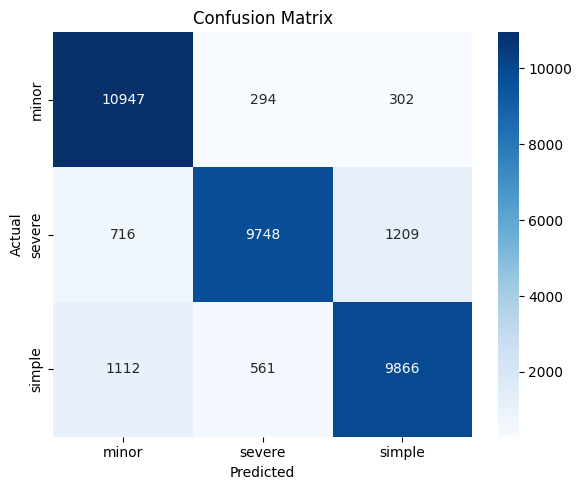

🎯 Weighted F1 Score: 0.878848544778953


In [16]:
from xgboost import DMatrix
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Convert X_test to DMatrix
dvalid = DMatrix(X_test)

# 2. Get class probabilities, then get predicted class (argmax)
y_probs = xgb_model.predict(dvalid)
y_pred = np.argmax(y_probs, axis=1)

# 3. Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# 4. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 5. F1 Score
print("🎯 Weighted F1 Score:", f1_score(y_test, y_pred, average='weighted'))


In [17]:
from sklearn.metrics import accuracy_score

def check_overfitting_booster(model, X_train, y_train, X_test, y_test):
    dtrain = DMatrix(X_train)
    dtest = DMatrix(X_test)

    # Predict class labels
    train_preds = np.argmax(model.predict(dtrain), axis=1)
    test_preds = np.argmax(model.predict(dtest), axis=1)

    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    if train_acc - test_acc > 0.1:
        print("⚠️ Potential Overfitting")
    elif test_acc < 0.6:
        print("⚠️ Potential Underfitting")
    else:
        print("✅ Model generalizes well")

# Call the function using your trained Booster model
check_overfitting_booster(xgb_model, X_train, y_train, X_test, y_test)


Training Accuracy: 0.9663
Test Accuracy: 0.8793
✅ Model generalizes well


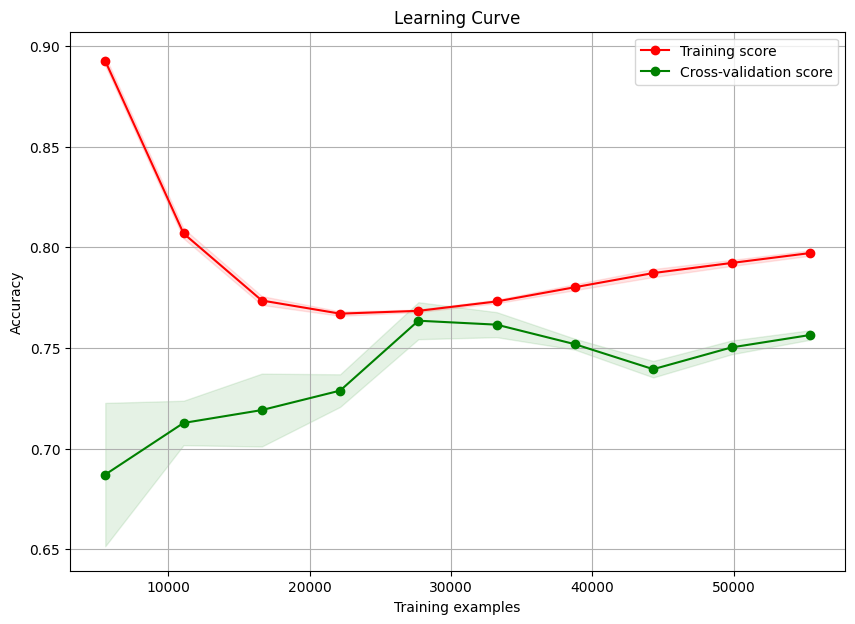


--- Numerical Learning Curve Data ---
Train Size: 5537
  Training Score (mean): 0.8925 (std: 0.0023)
  Cross-validation Score (mean): 0.6871 (std: 0.0356)
Train Size: 11074
  Training Score (mean): 0.8068 (std: 0.0025)
  Cross-validation Score (mean): 0.7127 (std: 0.0110)
Train Size: 16611
  Training Score (mean): 0.7735 (std: 0.0022)
  Cross-validation Score (mean): 0.7191 (std: 0.0181)
Train Size: 22148
  Training Score (mean): 0.7670 (std: 0.0011)
  Cross-validation Score (mean): 0.7288 (std: 0.0081)
Train Size: 27686
  Training Score (mean): 0.7684 (std: 0.0006)
  Cross-validation Score (mean): 0.7635 (std: 0.0092)
Train Size: 33223
  Training Score (mean): 0.7730 (std: 0.0009)
  Cross-validation Score (mean): 0.7615 (std: 0.0062)
Train Size: 38760
  Training Score (mean): 0.7801 (std: 0.0015)
  Cross-validation Score (mean): 0.7518 (std: 0.0027)
Train Size: 44297
  Training Score (mean): 0.7871 (std: 0.0020)
  Cross-validation Score (mean): 0.7394 (std: 0.0041)
Train Size: 49834


In [18]:
# === Learning Curve ===
pipeline = Pipeline([
    ('smote', SMOTENC(categorical_features=cat_indices_fs, random_state=42)),
    ('model', lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.3,
        objective='multiclass',
        num_class=len(np.unique(y_en)),
        random_state=42
    ))
])

train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=X_df,
    y=y_en,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

print("\n--- Numerical Learning Curve Data ---")
for i, size in enumerate(train_sizes):
    print(f"Train Size: {int(size)}")
    print(f"  Training Score (mean): {train_scores_mean[i]:.4f} (std: {train_scores_std[i]:.4f})")
    print(f"  Cross-validation Score (mean): {val_scores_mean[i]:.4f} (std: {val_scores_std[i]:.4f})")

In [19]:
# === Learning Curve Interpretation ===
print("\n--- Analysis and Interpretation ---")
train_final_score = train_scores_mean[-1]
val_final_score = val_scores_mean[-1]
score_gap = train_final_score - val_final_score
print(f"Final Training Score: {train_final_score:.4f}")
print(f"Final Cross-validation Score: {val_final_score:.4f}")
print(f"Score Gap: {score_gap:.4f}")

if score_gap > 0.1:
    print("\nInterpretation: Potential Overfitting")
elif val_final_score < 0.6:
    print("\nInterpretation: Potential Underfitting")
else:
    print("\nInterpretation: Model generalizes reasonably well")
    if score_gap < 0.05:
        print("Score gap is very small. Excellent generalization.")
    else:
        print("Score gap is moderate. You can try tuning regularization further.")

print("\nRecent Convergence:")
num_points_to_check = 3
for i in range(-num_points_to_check, 0):
    print(f"  Size: {int(train_sizes[i])}, Train Score: {train_scores_mean[i]:.4f}, CV Score: {val_scores_mean[i]:.4f}")

if val_scores_mean[-1] > val_scores_mean[-num_points_to_check]:
    print("Cross-validation score still improving. More data might help.")
else:
    print("CV score plateauing. Try different model or feature engineering.")


--- Analysis and Interpretation ---
Final Training Score: 0.7971
Final Cross-validation Score: 0.7564
Score Gap: 0.0407

Interpretation: Model generalizes reasonably well
Score gap is very small. Excellent generalization.

Recent Convergence:
  Size: 44297, Train Score: 0.7871, CV Score: 0.7394
  Size: 49834, Train Score: 0.7922, CV Score: 0.7502
  Size: 55372, Train Score: 0.7971, CV Score: 0.7564
Cross-validation score still improving. More data might help.
